# Random Walk: TD vs MC comparison

In this notebook we compare the performance of temporal difference (TD(0)) and Monte-Carlo.
The example we consider is a so-called Markov reward process,
i.e. a Markov decision process without actions.

For a more detailed description see Example 6.2, page 125, in Sutton & Barto.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

The environment is a finite, integer random walk of a given length,
with the agent starting in the middle of the way.

Each step they go left or right with equal probability.

The two outermost states (`0` and `length-1`) are terminal.

When the agent enters state `length-1` they receive a reward of +1, anytime else 0.

In [2]:

class RandomWalk:
    def __init__(self, length):
        self.length = length
        self.pos = self.length // 2
    
    def step(self):
        if self.pos == 0 or self.pos == self.length - 1:
            return self.pos, 0
        if np.random.uniform() < 0.5:
            self.pos += 1
        else:
            self.pos -= 1
        reward = 0
        if self.pos == self.length - 1:
            reward = 1
        return self.pos, reward
    
    def reset(self):
        self.pos = self.length // 2
        return self.pos



Set the length of the random walk used below.

In [3]:
LENGTH = 7

Create an instance and test the environment

In [4]:
rw = RandomWalk(LENGTH)

In [5]:
rw.reset()

3

In [6]:
rw.step()

(2, 0)

## 1. Monte-Carlo

First, we define a small helper function to check if a state is terminal.

In [7]:
def isTerminal(pos, length):
    return pos == 0 or pos == length - 1

Next, we define the code for a single episode of MC.
The value function is passed as `values` and updated in place.

In [8]:

def monteCarloEpisode(randomWalk: RandomWalk, values, alpha):
    # Initialize new random walk etc.
    randomWalk.reset()
    
    # Generate an episode
    path = [randomWalk.pos]
    rewards = [0]
    while True:
        pos, reward = randomWalk.step()
        rewards.append(reward)
        if isTerminal(pos, randomWalk.length):
            break
        path.append(pos)
    
    # Update values
    T = len(path)
    G = 0
    for t in reversed(range(T)):
        G += rewards[t+1]
        if not path[t] in path[0:t]:
            values[path[t]] += alpha * (G - values[path[t]])


In [9]:
# Perform MC by running many episodes
alpha = 0.02
values = [0] * LENGTH
randomWalk = RandomWalk(LENGTH)

for i in range(1000):
    monteCarloEpisode(randomWalk, values, alpha)

print(values)


[0, 0.16080983061649168, 0.3305402401218774, 0.5156421700274963, 0.6764360756320892, 0.8540873743902342, 0]


## 2. TD(0)

Next, we define the code for a single episode of TD(0).
The value function is passed as `values` and updated in place.

In [10]:

def tdEpisode(randomWalk: RandomWalk, values, alpha):
    # Initialize new random walk etc.
    randomWalk.reset()

    # Generate an episode, updating values in the process
    terminal = False
    while not terminal:
        oldPos = randomWalk.pos
        newPos, reward = randomWalk.step()
        values[oldPos] = values[oldPos] + alpha * (reward + values[newPos] - values[oldPos])
        terminal = isTerminal(newPos, randomWalk.length)


In [11]:
# Perform TD(0) by running many episodes
alpha = 0.02
values = [0] * LENGTH
randomWalk = RandomWalk(LENGTH)

for i in range(1000):
    tdEpisode(randomWalk, values, alpha)

print(values)

[0, 0.15934675159991837, 0.347462622172328, 0.49104644383351337, 0.666949190657535, 0.8134614074892409, 0]


## Comparison

Note that the true value of state $s$ is $s / (LENGTH - 1)$.
We use this to compare the error made by each method.

In [12]:
TRUE_VALUES = [i / (LENGTH - 1) for i in range(LENGTH)]

def computeRMS(values):
    errors = [v - t for v, t in zip(values[1:-1], TRUE_VALUES[1:-1])]
    return np.sqrt(np.mean(np.square(errors)))

First we recreate the left graph from p. 125, Sutton & Barto, showing the value function for different numbers of episodes $n$.

In [28]:
def plotValueSteps(showN, alpha):
    values = [0.5] * LENGTH
    values[0] = 0
    values[-1] = 0

    randomWalk = RandomWalk(LENGTH)
    
    n = np.max(showN) + 1
    
    # Perform TD, plotting the values of steps in showN
    for i in range(n):
        if i in showN:
            plt.plot(values[1:-1], label="n = " + str(i))
        tdEpisode(randomWalk, values, alpha)
    
    plt.plot(TRUE_VALUES[1:-1], linestyle='dashdot', label="true values")

    plt.legend()
    plt.show()

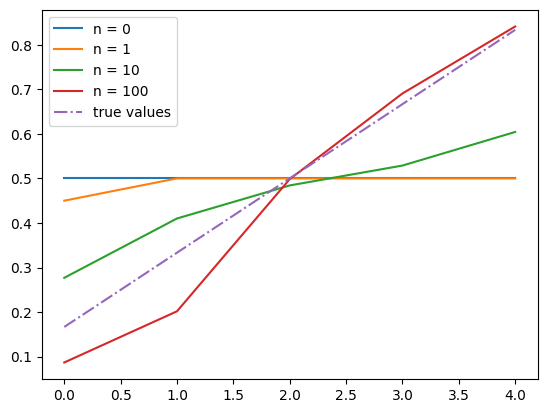

In [31]:
plotValueSteps([0, 1, 10, 100], 0.1)

Next, we define a function that performs several TD/MC episodes and computes the RMS after each episode.

In [15]:

def computeRMSs(alpha, nEpisodes, xxxEpisode):
    randomWalk = RandomWalk(LENGTH)
    rms = []
    values = [0.5] * LENGTH
    values[0] = 0
    values[-1] = 0
    for j in range(nEpisodes):
        xxxEpisode(randomWalk, values, alpha)
        rms.append(computeRMS(values))
    return rms


Using the function above,
we plot the RMS vs. the number of training episodes for both methods and different values of `alpha`.

MC...
0.01
0.02
0.03
0.04
TD...
0.01
0.05
0.1
0.2


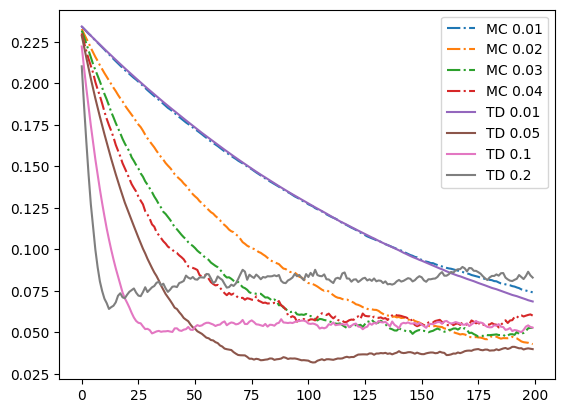

In [16]:

def movingAverage(a, k):
    return np.convolve(a, np.ones(k), 'valid') / k

# Compared alphas
alphasMC = [0.01, 0.02, 0.03, 0.04]
alphasTD = [0.01, 0.05, 0.10, 0.20]

# Number of episodes per experiment
nEpisodes = 200

# Number of experiments
nExperiments = 100

print('MC...')
for i, alpha in enumerate(alphasMC):
    print(alpha)
    rmsList = [computeRMSs(alpha, nEpisodes, monteCarloEpisode) for _ in range(nExperiments)]
    rms = np.mean(rmsList, axis=0)
    plt.plot(rms, linestyle='dashdot', label='MC {}'.format(alpha))

print('TD...')
for i, alpha in enumerate(alphasTD):
    print(alpha)
    rmsList = [computeRMSs(alpha, nEpisodes, tdEpisode) for _ in range(nExperiments)]
    rms = np.mean(rmsList, axis=0)
    plt.plot(rms, linestyle='solid', label='TD {}'.format(alpha))


plt.legend()
plt.show()
